# GNN Notebook
*This notebook is based on the colab notebooks at https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html*

In this notebook we will try out some of the Graph Neural Network methods discussed in Lecture 3. For a recap of the theory go back to the slides from week 3.

Luckily for us many of the common GNN models already have available implementations in PyTorch.

However, they are implemented in the package `pytorch-geometric` which can be very sensitive to torch and cuda versions when installing. Therefore, unless you are a pip expert, we suggest you upload this notebook to Google Drive and run as a Google Colab Notebook.


First we need to install `torch-geometric` on the Google VM as it is not a standard package in Colab

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

Next we need some standard (and by now familiar) packages for training, visualization etc.

In [2]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Node classification

First we will consider the task of node classification.
The goal of the task is to classify unlabeled nodes in a semi-labelled network.
To visualize the task lets take at look at one of the most famouse graphs in datascience - the [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

The graph is an overview over which of the 34 students, the nodes in the graph, interacted outside of the karateclub, here indicated by an edge.

*''Fun'' fact: This graph is so famous that there is a [Zachary's Karate Club Club](https://networkkarate.tumblr.com/), data scientists are weird like that.*


Pytorch-Geometric comes with some really nice datasets ready to use, so lets get the KarateClub dataset

In [3]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]

OSError: [WinError 127] The specified procedure could not be found

The dataset comes with some statistics about the graph. Take a look and see if you can remember what they mean - otherwise Lecture 3 might be worth a revisit.

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('======================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Lets take a look at the data itself.
The node features of the graph are in `data.x`. The Karate Club graph has no node features so this is just an identity matrix.

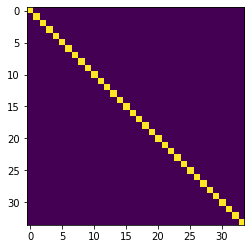

In [ ]:
plt.imshow(data.x)

The information about the connections in the graph is given in the edge list format in `data.edge_index`

In [ ]:
data.edge_index.T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

The other format to give the connections in a graph is by the adjacancy matrix.
The data is exactly the same so you can convert the edge list to an adjacancy matrix

In [ ]:
#adj_matrix = 
# Your code here

# Solution
from torch_geometric.utils import to_scipy_sparse_matrix
adj_matrix = to_scipy_sparse_matrix(data.edge_index).todense()

Since the adjacancy matrix is a matrix (...) we can visualize it with `plt.imshow`

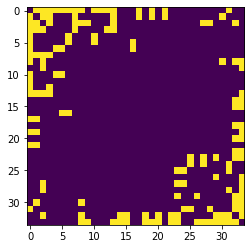

In [ ]:
plt.imshow(adj_matrix)

The labels of the nodes is saved in `data.y`

In [ ]:
data.y

tensor([0, 0, 0, 0, 1, 1, 1, 0, 3, 3, 1, 0, 0, 0, 3, 3, 1, 0, 3, 0, 3, 0, 3, 2,
        2, 2, 3, 2, 2, 3, 3, 2, 3, 3])

We can then use the graph to visualize the node classification task.
First we mask some of the labels.


In [ ]:
import random
masked_labels = data.y.clone()
random_nodes = random.sample(list(range(len(masked_labels))), 4)
for node in random_nodes:
    masked_labels[node] = 4

So the graph we have is semi-labelled, i.e. some nodes are labelled, some are not. (Note that here the "unlabelled" nodes are just labelled as a non-existing class 4 for visualizing)

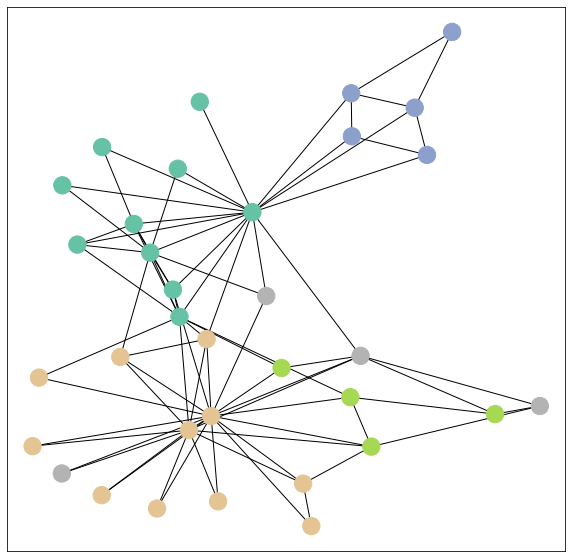

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=masked_labels, cmap="Set2")

The goal is then to infer the missing node labels based on the graph and features to get as close as possible to the true labels:

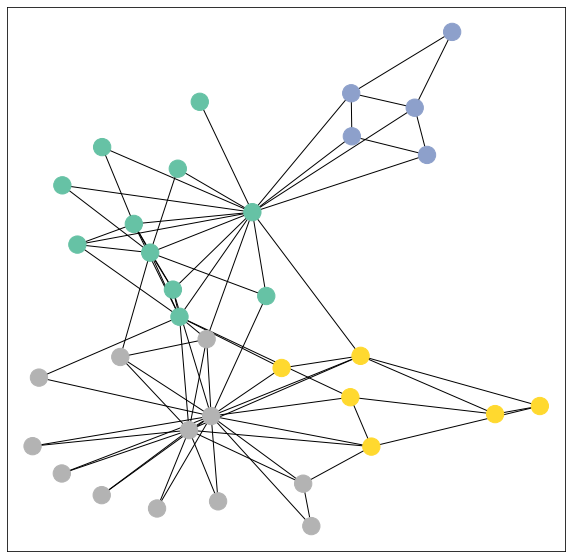

In [ ]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=data.y, cmap="Set2")

# Node classification on semi-labelled graph

Instead of doing node classification on the small Karate Club graph we will turn to a much larger graph. Namely the [Cora dataset](https://paperswithcode.com/dataset/cora). The dataset consists of 2708 publications, each represented by a node. The edges in the graph are citations (made undirected). The feature of each node is a binary Bag-Of-Word vector using a dictionary of 1433 words.

Again the dataset available in pytorch_geometric

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora')


along with some statistics:

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Worth noting here is the "Training node label rate" - We are trying to classify all of the nodes using a graph with only 0.05% labels during traning!

For this notebook we will use the traning and the test set. In order to get the test and training labels we use a mask to extract the label sets from all of the labels:

In [ ]:
train_labels = data.y[data.train_mask]
test_labels = data.y[data.test_mask]

print(f"Number of train labels: {len(train_labels)}")
print(f"Number of test labels: {len(test_labels)}")

Number of train labels: 140
Number of test labels: 1000


So we have 140 train labels that we train on. We will then test the classification accuracy on 1000 test labels.

In [ ]:
data = dataset[0] # Select the graph as data.

# Classification with a simple MLP network


First we will create a baseline to compare the GCN model against.

If we see each node as a seperate observation, the task becomes classification based on a BoW vector - something that can be done with multiple different ML architectures.
Here we will create a simple multi layer perceptron (MLP) model using simple linear layers.

The model takes as input the 1433 dimensional BoW vector and returns a 7 dimensional vector of logits for the different clases.

Initially, let's try an implementation with 2 layers:

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

If you never implemented a neural network in PyTorch, it is not that complicated. It resembles the functional API of Keras, but we always "encapsulate" our neural network models in a Python class that extends the ``nn.Module`` class of PyTorch. Then, all we need to do is define the ``__init__()`` and ``forward()`` methods that initialize the networks layers and define a forward pass through the neural network, respectively. 

See if the following code makes sense to you. Otherwise, don't be shy to ask for additional clarifications :-)

In [ ]:
# Implement a simple 2 layer MLP that take in dataset.num_features and returns dataset.num_classes logits

class Simple_MLP(nn.Module):
    def __init__(self, n_in, n_hid, n_out):
        super().__init__()
        
        # Initialize neural network layers
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)

        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        
    def forward(self, x):
        # Define forward pass through the neural network - i.e. the sequence of layers and transformations of the inputs x
        x = self.fc1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x

Next we set up the model, loss function and optimizer.
Below init the model with the init arguments you implementation needs.
For the loss function we use `nn.CrossEntropyLoss` that calculates the cross entropy from logits, i.e. no need to do softmax of the logits outselves.
Lastly we use Adam as optimizer.

In [ ]:
mlp = Simple_MLP(n_in=dataset.num_features, n_hid=16, n_out=dataset.num_classes) # YOUR CODE HERE
print(mlp)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)

Simple_MLP(
  (fc1): Linear(in_features=1433, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=7, bias=True)
)


Next we do the trainning, note here that we need to use the mask on the logit outputs to extract the node labels to compare to the test and training labels.

In [ ]:
def train():
    mlp.train()
    optimizer.zero_grad()
    out = mlp(data.x)
    loss = loss_func(out[data.train_mask], train_labels) # We use the dataset mask to only base the loss on the training data
    loss.backward()
    optimizer.step()
    return loss

def test():
    mlp.eval()
    out = mlp(data.x)
    pred = out.argmax(dim=1) # Go from logits to class prediction
    test_correct = pred[data.test_mask] == test_labels  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / len(test_labels)  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 401):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9897
Epoch: 002, Loss: 1.8879
Epoch: 003, Loss: 1.7667
Epoch: 004, Loss: 1.6907
Epoch: 005, Loss: 1.6109
Epoch: 006, Loss: 1.5364
Epoch: 007, Loss: 1.4014
Epoch: 008, Loss: 1.3624
Epoch: 009, Loss: 1.1554
Epoch: 010, Loss: 1.1207
Epoch: 011, Loss: 1.0597
Epoch: 012, Loss: 0.9734
Epoch: 013, Loss: 0.8937
Epoch: 014, Loss: 0.8542
Epoch: 015, Loss: 0.8246
Epoch: 016, Loss: 0.8310
Epoch: 017, Loss: 0.7847
Epoch: 018, Loss: 0.6820
Epoch: 019, Loss: 0.6669
Epoch: 020, Loss: 0.6589
Epoch: 021, Loss: 0.5445
Epoch: 022, Loss: 0.4734
Epoch: 023, Loss: 0.5307
Epoch: 024, Loss: 0.4215
Epoch: 025, Loss: 0.5724
Epoch: 026, Loss: 0.4549
Epoch: 027, Loss: 0.4962
Epoch: 028, Loss: 0.4624
Epoch: 029, Loss: 0.4511
Epoch: 030, Loss: 0.3837
Epoch: 031, Loss: 0.3271
Epoch: 032, Loss: 0.3918
Epoch: 033, Loss: 0.4360
Epoch: 034, Loss: 0.3358
Epoch: 035, Loss: 0.3313
Epoch: 036, Loss: 0.2991
Epoch: 037, Loss: 0.2754
Epoch: 038, Loss: 0.2116
Epoch: 039, Loss: 0.2745
Epoch: 040, Loss: 0.2814


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5810


Given that there are 16 different classes in the dataset a simple MLP model should be able to achieve a test accuracy around ~0.55 - Not great but it is certainly better than random guessing.

However the MLPs classification is only based on node features i.e. the bag-of-word. Hence all of the information in the graph structure is not used at all.



# Classification with a GCN [Kipf et al]

GN's aim to make proper use of this data. One of the first GN models to do this is the Graph Convolution Network (GCN) from Kipf et al. (https://arxiv.org/abs/1609.02907).

The model is a simplifaction spectral convolution but can also be thought of as message passing between the nodes or a generalization of CNN to graphs. See slides from lecture 3 for a recap.

The propagation rule in the GCN is defined as

$H^{(l+1)}=f(H^{(l)}, A)=\sigma\left(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)}\right)$

where $H^{(l)}$ is the embeddings in the $l$'th layer, $\tilde{A}=A+I_{N}$ where $A$ is the adjacancy matrix and $\tilde{D}_{i i}=\sum_{j} \tilde{A}_{i j}$.

The $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$ part of the rule aggregates and normalizes over the nodes 1-hop neighbourhood propagating the signal through the graph. Since each layer propagates to the 1-hop neighbours, what happens if we stack multiple layers?

The GCN layer is also implemented in pytorch_geometric in `torch_geometric.nn.GCNConv`, hence implementing a GCN model is no harder than the simple MLP model. All you need to do is to use the ``GCNConv`` class from ``torch_geometric.nn`` instead of "standard" fully-connected layers like you did before. Can you now try to adapt the code from the previous fully connected neural network to use ``GCNConv`` layers instead?  

Implement a 2-layer GCN model with the same dimension in the hidden layer as your MLP implementation:

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, n_in, n_hid, n_out):
        super().__init__()

        self.layer1 = GCNConv(n_in, n_hid)
        self.layer2 = GCNConv(n_hid, n_out)

    def forward(self, x, edge_index):
        x = self.layer1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.layer2(x, edge_index)
        
        return x

With the GCN implementation we can use the same training procedure as for the MLP model

In [ ]:
gcn = GCN(n_in=dataset.num_features, n_hid=16, n_out=dataset.num_classes) # YOUR CODE HERE init your implementation of GCN
print(gcn)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

GCN(
  (layer1): GCNConv(1433, 16)
  (layer2): GCNConv(16, 7)
)


In [ ]:
def train():
    gcn.train()
    optimizer.zero_grad()
    out = gcn(data.x, data.edge_index)
    loss = loss_func(out[data.train_mask], train_labels) # We use the dataset mask to only base the loss on the training data
    loss.backward()
    optimizer.step()
    return loss

def test():
    gcn.eval()
    out = gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1) # Go from logits to class prediction
    test_correct = pred[data.test_mask] == test_labels  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / len(test_labels)  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 401):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9452
Epoch: 002, Loss: 1.8246
Epoch: 003, Loss: 1.6928
Epoch: 004, Loss: 1.5460
Epoch: 005, Loss: 1.3542
Epoch: 006, Loss: 1.2215
Epoch: 007, Loss: 1.0898
Epoch: 008, Loss: 0.9599
Epoch: 009, Loss: 0.8495
Epoch: 010, Loss: 0.7506
Epoch: 011, Loss: 0.6113
Epoch: 012, Loss: 0.5574
Epoch: 013, Loss: 0.5015
Epoch: 014, Loss: 0.4673
Epoch: 015, Loss: 0.3953
Epoch: 016, Loss: 0.3492
Epoch: 017, Loss: 0.3012
Epoch: 018, Loss: 0.2565
Epoch: 019, Loss: 0.2329
Epoch: 020, Loss: 0.2129
Epoch: 021, Loss: 0.2032
Epoch: 022, Loss: 0.1692
Epoch: 023, Loss: 0.1350
Epoch: 024, Loss: 0.1612
Epoch: 025, Loss: 0.1317
Epoch: 026, Loss: 0.1339
Epoch: 027, Loss: 0.0966
Epoch: 028, Loss: 0.1042
Epoch: 029, Loss: 0.1008
Epoch: 030, Loss: 0.1348
Epoch: 031, Loss: 0.0946
Epoch: 032, Loss: 0.0946
Epoch: 033, Loss: 0.0969
Epoch: 034, Loss: 0.1064
Epoch: 035, Loss: 0.0668
Epoch: 036, Loss: 0.0640
Epoch: 037, Loss: 0.0531
Epoch: 038, Loss: 0.0768
Epoch: 039, Loss: 0.0581
Epoch: 040, Loss: 0.0497


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8000


A GN model takes the graph structure into account and therefore a GN model of simillar size to the MLP model should be able to do much better - here atleast around ~0.80 accuracy.

To verify that the models are simillar size we can count the number of trainable parameters:

In [ ]:
mlp_num_params = 0
for p in mlp.parameters():
    count = 1
    for s in p.size():
        count *= s
    mlp_num_params += count

gcn_num_params = 0
for p in gcn.parameters():
    count = 1
    for s in p.size():
        count *= s
    gcn_num_params += count

print(f"MLP model parameters: {mlp_num_params}")
print(f"GCN model parameters: {gcn_num_params}")


MLP model parameters: 23063
GCN model parameters: 23063
